In this Python notebook, we will be extracting the URLs to many different Wikipedia pages then using those URLs to extract all the sentences from those same Wikipedia pages. The sentences will then be cleaned, explored, and used to train a predictive language model. We will start by extracting all the URLs we want. 

In [3]:
"""This first section collects the URLs that we will use to gather our data. Essentially we start with the URL below as our starting point and we scrape all the URLs on that given wikipedia page.
This gives us a long list of URls each correspodning to a wikipedia page. From there we scrape all the links of each of those pages."""

import requests
from bs4 import BeautifulSoup as bsoup

# def collect_urls(url):
#     response = requests.get(url)
#     soup = bsoup(response.text, 'lxml')
#     body = soup.find(id="bodyContent") #grab the body of the wiki page
#     paragraphs = body.find_all('p') #select all the paragraphs in the body

#     valid_urls = [] #create empty list to store URLs
#     for paragraph in paragraphs: #iterate through each paragraph
#         for link in paragraph.find_all('a'): #find all links
#             href = link.get('href')
#             if href is not None and 'https' not in href and '#cite_note' not in href: #we only want links that go to other wiki pages, which will only cite the extension, not any new link starting with http
#                 url = 'https://en.m.wikipedia.org'+href #append the link to the starter URL identified above
#                 valid_urls.append(url) #append the url the empty list 

#     return list(set(valid_urls))

# url = "https://en.wikipedia.org/wiki/History_of_the_United_States"

# base_page_urls = collect_urls(url) #collect urls from starting page 

# all_urls = [] #create new list to store all the urls
# all_urls.extend(base_page_urls) #extend the base page urls to the new list 

# for url in base_page_urls: #iterate through the base page urls and pass each one to the function abovee
#     new_urls = collect_urls(url)
#     all_urls.extend(new_urls) #extend the urls from each page from the base page urls to the list of all urls 


# all_urls = list(set(all_urls)) #get rid of duplicates

# print(len(all_urls))

We now have a large list of Wikipedia article links. We will use these links to access and scrape the text from each page. We will tokenize the text into sentences and store them in a pandas DataFrame. 

In [4]:
from urllib.parse import quote
from nltk.tokenize import sent_tokenize
import pandas as pd

# #iterate through all the URLs we scraped and grab all the text from each page, tokenizing the text into sentences

# import pandas as pd
# urls = pd.read_csv('/Users/loganbarger/Documents/University of Denver/Data Science Tools 1/DSTFinalProject/url_data.csv') #using the URL csv saves time so we don't need to scrape the URLs every time
# all_urls = urls['URLs'].tolist()

# data = []
# for i in range(len(all_urls)):
#     print(i) #allows us to watch progress, this took about 11 hours to run. 
#     temp_url = all_urls[i]

#     encoded_url = quote(temp_url) #encode the entire string as a URL, this ensures that URLs ending with special characters are found correctly 

#     try: #occassionally we come across a URL that has no webpage, this will skip over those 
#         temp_response = requests.get(temp_url)
#     except:
#         continue

#     temp_soup = bsoup(temp_response.text, 'lxml')
#     if temp_soup is not None: 
#         temp_body = temp_soup.find('div', class_='mw-body-content')
#     if temp_body is not None:
#         temp_paragraphs = temp_body.find_all('p')
        
#         body_text = ' '.join(paragraph.text for paragraph in temp_paragraphs)
            
#         sentences = sent_tokenize(body_text)
#         data.extend(sentences) 

# data_df = pd.DataFrame(data, columns=['original_text'])

In this section we will be cleaning and processing our data. We will be removing grammar, stopwords, lemmatizing the words in the sentences, tagging words etc. It turns out, the amount of data we collected was well into the tens of millions of lines, so to make this more manageable we take a random 5% of our data. 

In [5]:
#all_data = pd.read_csv('file/directory/to/the/old/data)
#sample_data = all_data.sample(frac=0.05, random_state=42) #use only 5% of the original data
sample_data = pd.read_csv('/Users/loganbarger/Documents/University of Denver/Data Science Tools 1/DSTFinalProject/project_sample_data.csv')


In [5]:
import re
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from joblib import Parallel, delayed

nltk.download("words") 
nltk.download('punkt')
nltk.download('wordnet')

#remove all punctuation, \n, and footnotes
def remove_patterns(text):
    text = re.sub(r'\[\d+\]\s*', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

#remove stopwords
def remove_stopwords(text):
    #collect all stopwords
    stop_words = set(stopwords.words('english'))

    #Split the sentence
    words = text.split()

    #Grab only the words not in the stopwords set
    non_stopwords = [word for word in words if word.lower() not in stop_words]

    #Combine words back into sentence 
    new_text = str(' '.join(non_stopwords))
    
    return new_text

#lemmatize a text
lemmatizer = WordNetLemmatizer()

def lemmatize_text(input_text):
    # Tokenize the sentence
    tokens = nltk.word_tokenize(input_text)
    
    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the lemmatized tokens back into a sentence 
    lemmatized_text = ' '.join(lemmatized_tokens)

    return lemmatized_text


[nltk_data] Downloading package words to
[nltk_data]     /Users/loganbarger/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/loganbarger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/loganbarger/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
#First we will remove punctuation, then we will remove stopwords, then we will lemmatize

sample_data['no_punct'] = sample_data['original_text'].apply(remove_patterns)

#removing footnotes made some of the values blank, we will get rid of those now
sample_data = sample_data[sample_data['original_text'] != '']
sample_data = sample_data[sample_data['original_text'] != '"'] #because some quotes are longer than a sentence, when the quote is tokenized, there is a dangling " left over
sample_data = sample_data.reset_index(drop=True) #reset index


In [8]:
#remove stopwords
sample_data['no_stopwords'] = sample_data['no_punct'].apply(remove_stopwords) #create new column that has no stopwords

#Some sentences when lemmatized turn into only stop words, so when stopwords are removed, a blank value is given to the 'no_stopwords' column, lets remove these rows as the sentences are too simple
sample_data = sample_data[sample_data['no_stopwords'] != '']
sample_data = sample_data.dropna(subset=['no_stopwords'])
sample_data = sample_data.reset_index(drop=True) #reset index

sample_data.head()

,original_text,no_punct,no_stopwords
0,Carboxylic acids react with bases to form carb...,Carboxylic acids react with bases to form carb...,Carboxylic acids react bases form carboxylate ...
1,[3] The commission fulfills its responsibiliti...,The commission fulfills its responsibilities u...,commission fulfills responsibilities IGRA comm...
2,[20] Reciting crime statistics from Philadelp...,Reciting crime statistics from Philadelphia fr...,Reciting crime statistics Philadelphia 1990s A...
3,"[6][5] On 8 November 1766, Portland married La...",On 8 November 1766 Portland married Lady Dorot...,8 November 1766 Portland married Lady Dorothy ...
4,Religiosity and religious fundamentalism predi...,Religiosity and religious fundamentalism predi...,Religiosity religious fundamentalism predicted...


In [9]:
#lemmatize the words

sentences = sample_data['no_stopwords'].to_list()

result_parallel = Parallel(n_jobs=-1)(delayed(lemmatize_text)((sentence)) for sentence in sentences)

sample_data['lemmatized'] = result_parallel

In [10]:
sample_data.to_csv('cleaned_data.csv', index=False)

In [11]:
cleaned_data = pd.read_csv('/Users/loganbarger/Documents/University of Denver/Data Science Tools 1/DSTFinalProject/cleaned_data.csv')
print(cleaned_data.dtypes)

original_text    object
no_punct         object
no_stopwords     object
lemmatized       object
dtype: object


Now that our data has been cleaned and some preprocessing has been done, we will do some data exploration and feature engineering. 

In [52]:
from nltk.tokenize import word_tokenize
from nltk import trigrams
from textblob import TextBlob
from nltk import pos_tag

"""This section is the EDA and feature engineering of our text data. We will look at word frequency, sentence length frequency, average sentence length, word length frequency, average word length, 
what percent of the sentences are stopwords, visualizing most common n-grams, creating a wordcloud, sentiment analysis using textblob, visualizing tagging frequencies, 
exploring sentence complexity etc"""

#Let's see what the sentence lengths are
def count_words(text): 
    text = text.split()
    return len(text)

#Explore what the average word length is
def avg_word_len(text): 
    string = str(text)
    string = string.split()
    if len(string) == 0:
        return 0
    return round(sum(len(word) for word in string) / len(string))

#Let's look at what percent of the sentences are stopwords
def percent_stopwords(text): #percent of words that are stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    count = 0
    for word in words:
        if word.lower() in stop_words:
            count += 1
    return round(count/len(words), 3)

#Let's create the trigrams for each sentence
def trigram(text):
    words = word_tokenize(text)
    my_trigrams = list(trigrams(words))
    return my_trigrams

#We will create another function which will extract the trigrams and return them as a list of strings instead of a list of tuples
def extract_trigrams(input):
    trigrams = []
    trigrams_converted = [[str(word) for word in trigram] for trigram in input]
    for value in trigrams_converted:
        trigram_str = ' '.join(value)
        trigrams.append(trigram_str)
    return trigrams

#Let's create a new feature which is a measure of the sentiment of the sentence
def sentiment(text):
    return TextBlob(text).sentiment.polarity

#We will also categorize the sentiment polarity into categories
def categorize(sentiment):
    if sentiment > 0:
        return 'Positive'
    elif sentiment < 0: 
        return 'Negative'
    else:
        return 'Neutral'

#Let's create another feature which will give the ratio of the types of words in the sentences

all_tags = {'Noun', 'Verb', 'Adjective', 'Adverb', 'Other'}

def tag_distribution(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    simple_tags = [simplify_tags(tag) for (_, tag) in pos_tags]
    
    counts = {tag: 0 for tag in all_tags}
    for tag in simple_tags:
        counts[tag] += 1 

    percents = {pos: round(count / len(words)*100, 3) for pos, count in counts.items()}
    return percents

#There is a lot of detail in the tagging method we used, so we will simplify the tags into five categories
def simplify_tags(tag):
    if tag.startswith('N'):
        return 'Noun'
    elif tag.startswith('V'):
        return 'Verb'
    elif tag.startswith('JJ'):
        return 'Adjective'
    elif tag.startswith('R'):
        return 'Adverb'
    else:
        return 'Other'

#Lastly let's create a column that is a list of every stopword in our original text. This will be helpful for visualizations down the road 
def gather_stopwords(text): #this fucntion removes stopwords 
    stop_words = set(stopwords.words('english'))
    words = text.split()
    all_stopwords = [word for word in words if word.lower() in stop_words]

    new_text = str(' '.join(all_stopwords))
    return new_text


In [13]:
#Create new column that will hold the count of words (sentence length)
cleaned_data['word_count'] = cleaned_data['original_text'].apply(count_words)

In [14]:
#Create two new columns which are average word lengths with and without stopwords
cleaned_data['avg_word_len_with_stopwords'] = cleaned_data['original_text'].apply(avg_word_len)
cleaned_data['avg_word_len_no_stopwords'] = cleaned_data['no_stopwords'].apply(avg_word_len)

In [15]:
#Create a new column which will be the ratio of words in our original sentence which are stopwords
cleaned_data['percent_stopwords'] = cleaned_data['original_text'].apply(percent_stopwords)

In [16]:
#Some sentences are too short when they don't have stopwords. because they are too simple we will remove them from the data 
cleaned_data = cleaned_data[cleaned_data['no_stopwords'].apply(lambda x: len(x) >= 3)]
#Now let's maake our trigrams
cleaned_data['trigrams'] = cleaned_data['no_stopwords'].apply(trigram)

In [17]:
#Run these two new columns through the trigram extract function which returns them as a list of strings instead of having them as a list of tuples
cleaned_data['trigrams_extracted'] = cleaned_data['trigrams'].apply(extract_trigrams)

In [54]:
#Create a new columns which will store a dictionary of the distribution of tags in our sentence
cleaned_data['tag_distribution'] = cleaned_data['no_stopwords'].apply(tag_distribution)

In [20]:
#Create two new columns which will be the sentiment rating (-1 to 1) and the sentiment category (Positive, Negative, or Neutral)
cleaned_data['sentiment'] = cleaned_data['original_text'].apply(sentiment)
cleaned_data['sentiment_category'] = cleaned_data['sentiment'].apply(categorize)

In [21]:
#Create a new column which will store a string of all the stopwords in our sentence. This is useful for visualizations down the road. 
cleaned_data['all_stopwords'] = cleaned_data['original_text'].apply(gather_stopwords)


In [55]:
cleaned_data.head()

,original_text,no_punct,no_stopwords,lemmatized,word_count,avg_word_len_with_stopwords,avg_word_len_no_stopwords,percent_stopwords,trigrams,trigrams_extracted,tag_distribution,sentiment,sentiment_category,all_stopwords
0,Carboxylic acids react with bases to form carb...,Carboxylic acids react with bases to form carb...,Carboxylic acids react bases form carboxylate ...,Carboxylic acid react base form carboxylate sa...,24,5,6,0.417,"[(Carboxylic, acids, react), (acids, react, ba...","[Carboxylic acids react, acids react bases, re...","{'Other': 0.0, 'Adjective': 21.429, 'Noun': 50...",0.000000,Neutral,with to in which the of the is with a
1,[3] The commission fulfills its responsibiliti...,The commission fulfills its responsibilities u...,commission fulfills responsibilities IGRA comm...,commission fulfills responsibility IGRA commis...,29,6,8,0.310,"[(commission, fulfills, responsibilities), (fu...","[commission fulfills responsibilities, fulfill...","{'Other': 11.111, 'Adjective': 11.111, 'Noun':...",0.500000,Positive,The its under The to more than or in
2,[20] Reciting crime statistics from Philadelp...,Reciting crime statistics from Philadelphia fr...,Reciting crime statistics Philadelphia 1990s A...,Reciting crime statistic Philadelphia 1990s Al...,17,6,7,0.294,"[(Reciting, crime, statistics), (crime, statis...","[Reciting crime statistics, crime statistics P...","{'Other': 9.091, 'Adjective': 0.0, 'Noun': 63....",0.000000,Neutral,from from the that will
3,"[6][5] On 8 November 1766, Portland married La...",On 8 November 1766 Portland married Lady Dorot...,8 November 1766 Portland married Lady Dorothy ...,8 November 1766 Portland married Lady Dorothy ...,22,6,6,0.227,"[(8, November, 1766), (November, 1766, Portlan...","[8 November 1766, November 1766 Portland, 1766...","{'Other': 18.75, 'Adjective': 0.0, 'Noun': 75....",0.250000,Positive,On a of of and
4,Religiosity and religious fundamentalism predi...,Religiosity and religious fundamentalism predi...,Religiosity religious fundamentalism predicted...,Religiosity religious fundamentalism predicted...,14,8,10,0.286,"[(Religiosity, religious, fundamentalism), (re...","[Religiosity religious fundamentalism, religio...","{'Other': 0.0, 'Adjective': 30.0, 'Noun': 50.0...",0.358333,Positive,and most in and


In [56]:
cleaned_data.to_csv('data_features.csv', index=False)

Now we have several new features created and put into our dataframe. Let's visualize these features and see what our data is like. 

In [6]:
data_features = pd.read_csv('/Users/loganbarger/Documents/University of Denver/Data Science Tools 1/DSTFinalProject/data_features.csv')

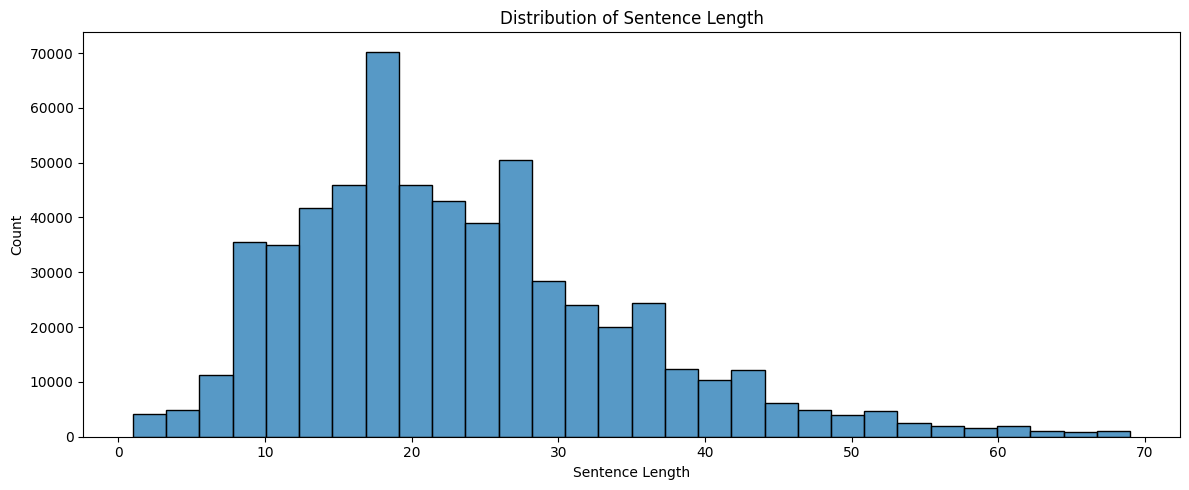

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
"""Now that we have all of our features we need, let's visualize them so we get an idea of what the data looks like."""

#First let's look at average sentence length
filter_sentence = data_features['word_count'] < 70
filtered_length = data_features[filter_sentence]

plt.figure(figsize=(12,5))
sns.histplot(filtered_length['word_count'], bins = 30)
plt.title('Distribution of Sentence Length')
plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.tight_layout()
plt.show()




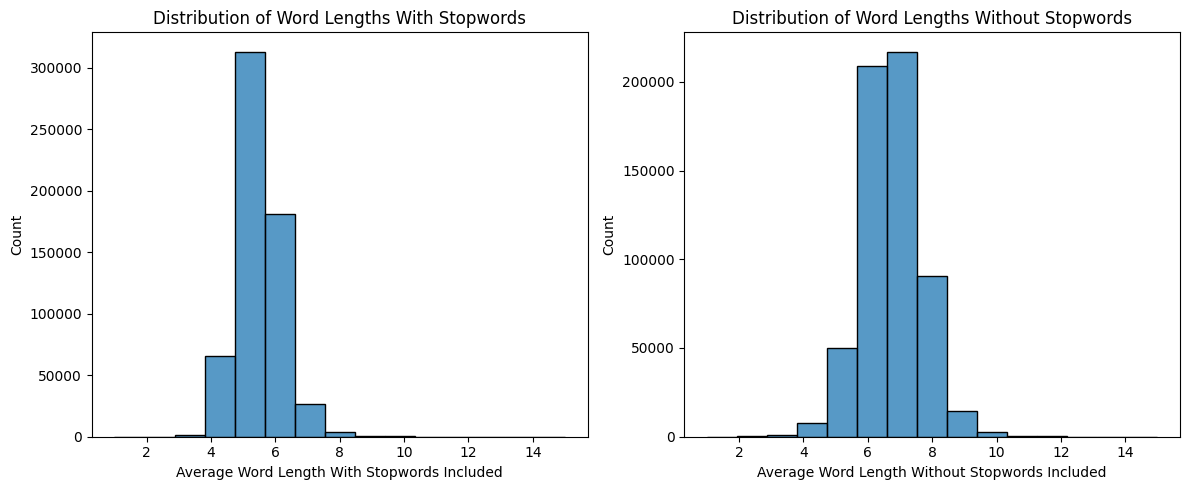

In [26]:
#Now let's look at average word length with and without stopwords
filter_for_words_stopwords = data_features['avg_word_len_with_stopwords'] <= 15
filtered_words_stopwords = data_features[filter_for_words_stopwords]

filter_for_words = data_features['avg_word_len_no_stopwords'] <= 15
filtered_words = data_features[filter_for_words]


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(filtered_words_stopwords['avg_word_len_with_stopwords'], bins = 15)
plt.xlabel('Average Word Length With Stopwords Included')
plt.ylabel('Count')
plt.title('Distribution of Word Lengths With Stopwords')

plt.subplot(1,2,2)
sns.histplot(filtered_words['avg_word_len_no_stopwords'], bins = 15)
plt.title('Distribution of Word Lengths Without Stopwords')
plt.xlabel('Average Word Length Without Stopwords Included')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

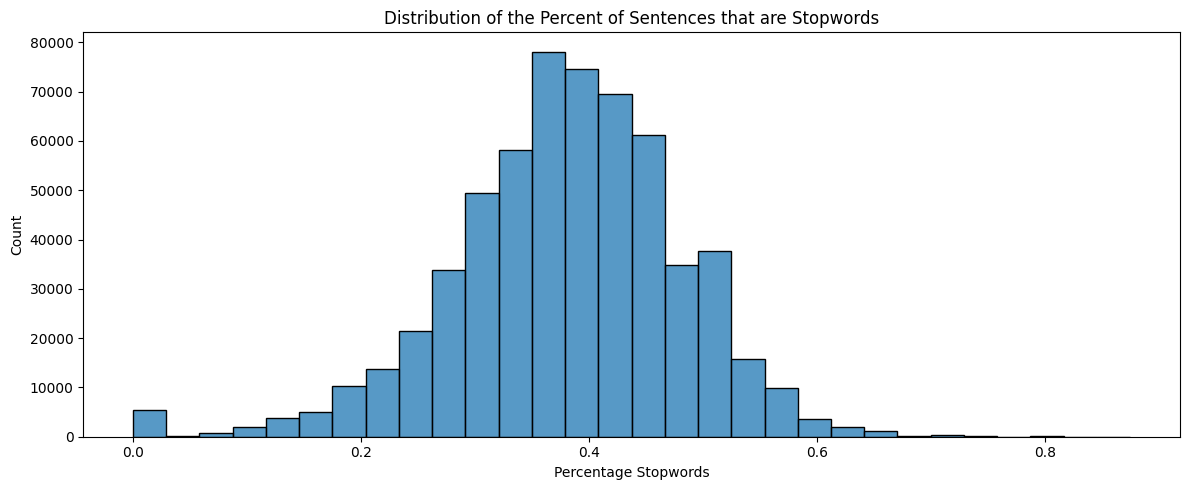

In [27]:
#Let's visualize the percentage of sentences that are stopwords
plt.figure(figsize=(12,5))
sns.histplot(data_features['percent_stopwords'], bins = 30)
plt.title('Distribution of the Percent of Sentences that are Stopwords')
plt.xlabel('Percentage Stopwords')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

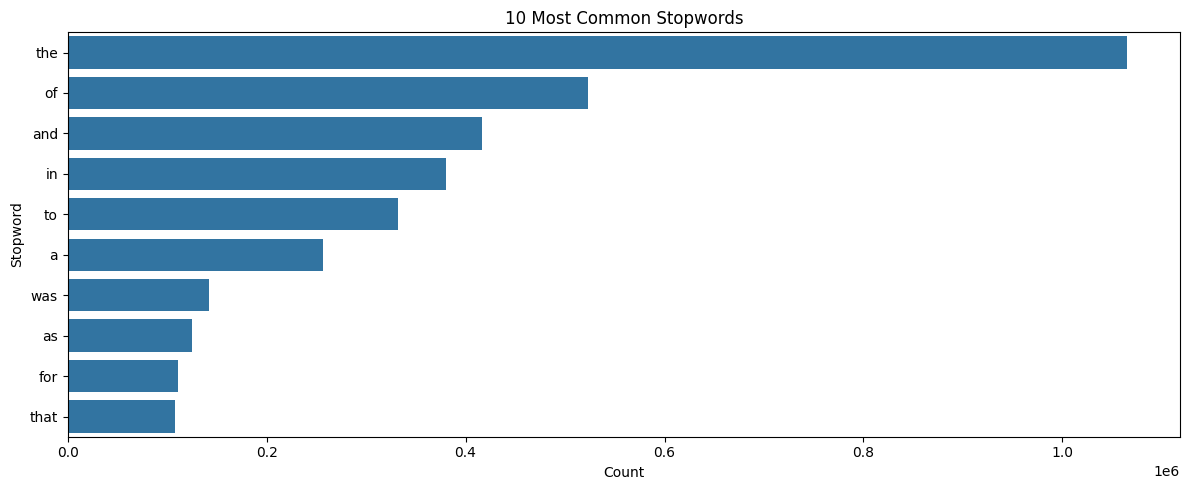

In [28]:
#Let's look at the most common stopwords

list_of_lists = data_features['all_stopwords'].to_list()

words_lists = [str(sublist).split() for sublist in list_of_lists if pd.notna(sublist)]
flat_list = [word.lower() for sublist in words_lists for word in sublist if word != '']

stopwords_counts = Counter(flat_list)
top_stopwords = stopwords_counts.most_common(10)
stopwords_df = pd.DataFrame(top_stopwords, columns=['Stopword', 'Count']) 
stopwords_df.head(20)

plt.figure(figsize=(12,5))
sns.barplot(x='Count', y='Stopword', data=stopwords_df)
plt.title('10 Most Common Stopwords')
plt.xlabel('Count')
plt.ylabel('Stopword')
plt.tight_layout()
plt.show()

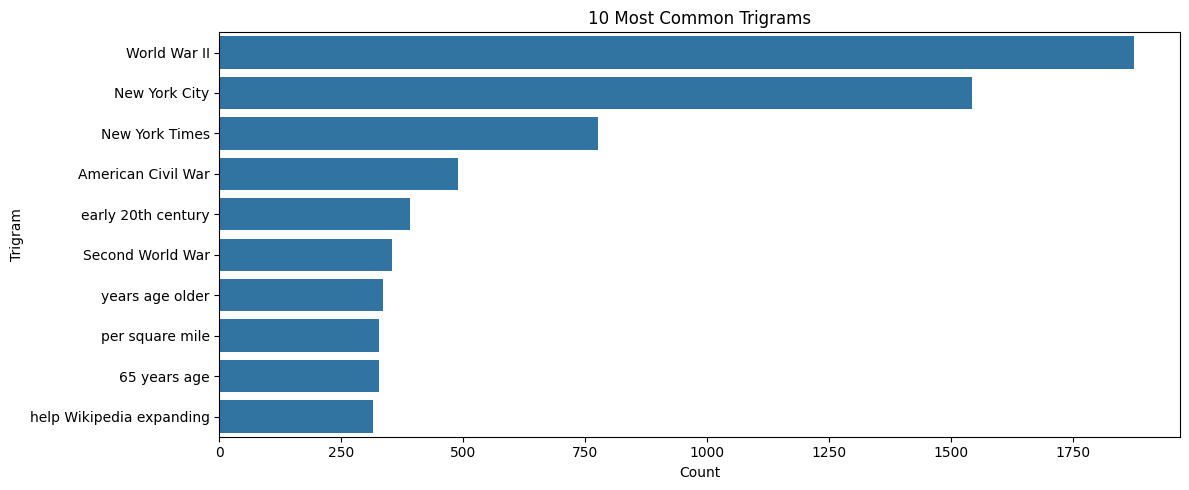

In [29]:
#Let's plot the most common trigrams before and after cleaning the text

from ast import literal_eval
data_features['trigrams_extracted'] = data_features['trigrams_extracted'].apply(literal_eval)

# Flatten the lists in the 'trigram_column'
all_trigrams = [trigram for trigrams_list in data_features['trigrams_extracted'] for trigram in trigrams_list]


trigram_counts = Counter(all_trigrams)
top = trigram_counts.most_common(10)
top_df = pd.DataFrame(top, columns=['Trigram', 'Count'])


plt.figure(figsize=(12,5))
sns.barplot(x='Count', y='Trigram', data=top_df)
plt.title('10 Most Common Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.tight_layout()
plt.show()

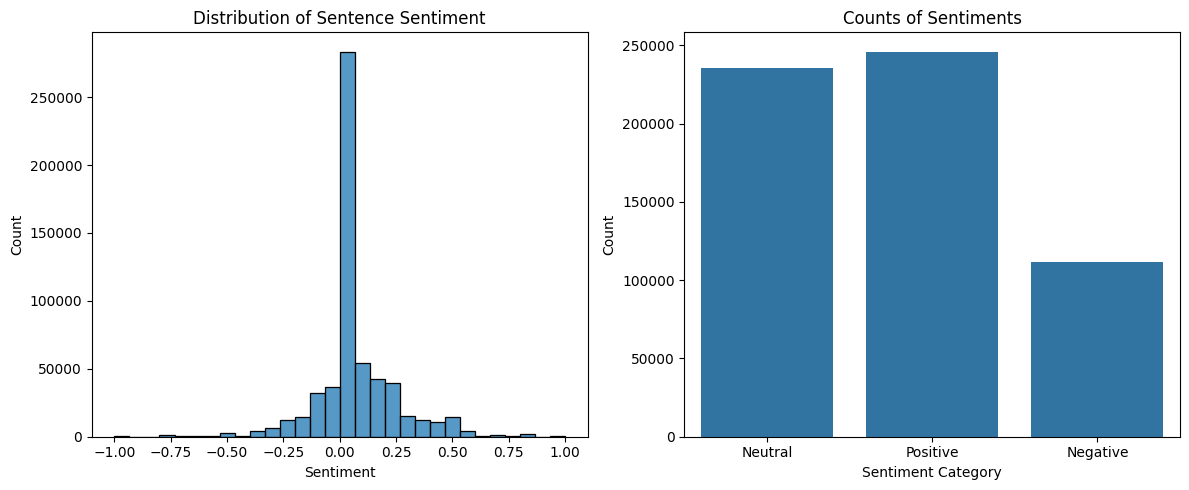

In [30]:
#We will now look at the sentiment analysis of our text 
all_sentiments = [value for value in data_features['sentiment_category']]
sentiment_counts = Counter(all_sentiments)
sentiment_df = pd.DataFrame.from_dict(sentiment_counts, orient='index', columns=['Count']).reset_index()
sentiment_df.head()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(data_features['sentiment'], bins = 30)
plt.title('Distribution of Sentence Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.barplot(x='index', y='Count', data=sentiment_df)
plt.title('Counts of Sentiments')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [9]:
#Lastly lets visualize the breakdown of pos tags in our sentences
list_of_dicts =  data_features['tag_distribution'].to_list()
df = pd.DataFrame.from_dict(list_of_dicts, orient='columns')

#avg_values = df.mean()

# plt.figure(figsize=(12,5))
# sns.barplot(x=avg_values.index, y=avg_values.values)
# plt.title('Average Percent Distribution of Tags')
# plt.xlabel('Average Percent for Each Tag')
# plt.ylabel('Tag')
# plt.tight_layout()
# plt.show()

In [120]:
from nltk import ngrams
from nltk.probability import FreqDist, ConditionalFreqDist
from sklearn.model_selection import train_test_split
import pandas as pd
df = pd.read_csv('/Users/loganbarger/Documents/University of Denver/Data Science Tools 1/DSTFinalProject/lemmatized_data.csv')

# Sample corpus
corpus = df['no_punct']

# Split the corpus into a training set and a testing set
train_corpus, test_corpus = train_test_split(corpus, test_size=0.2, random_state=42)

# Tokenize and create trigrams for the training set
train_tokens = [nltk.word_tokenize(sentence) for sentence in train_corpus]
train_trigrams = list(ngrams([word for sentence_tokens in train_tokens for word in sentence_tokens], 3))


# Create frequency distributions for the training set
train_freq_dist = FreqDist(train_trigrams)
train_cond_freq_dist = ConditionalFreqDist(((trigram[0], trigram[1]), trigram[2]) for trigram in train_trigrams)

# Function to predict the last three words of a sentence given the beginning
def predict_last_trigram(beginning, cond_freq_dist):
    beginning_tokens = nltk.word_tokenize(beginning)
    last_trigram = tuple(beginning_tokens[-2:])
    print(last_trigram)
    predicted_word = cond_freq_dist[last_trigram].max() 
    return predicted_word


lemmatized_data['beginning'] = lemmatized_data['original_text'].apply(lambda x: ' '.join(x.split()[:-3]))
def predictor(sentence):
    predicted_words = []
    for i in range(3):
        predicted_last_trigram = predict_last_trigram(sentence, train_cond_freq_dist)
        str(predicted_last_trigram)
        sentence += ' ' + str(predicted_last_trigram)
        predicted_words.append(predicted_last_trigram)
    return predicted_words

lemmatized_data.head()

#lemmatized_data['prediction'] = lemmatized_data['beginning'].apply(predictor)




,original_text,no_punct,lemmatized,no_stopwords,word_count,avg_word_len_with_stopwords,avg_word_len_no_stopwords,percent_stopwords,trigrams,cleaned_trigrams,sentiment,sentiment_category,tag_distribution,all_stopwords,beginning
0,The causes of the Great Depression in the early 20th century in the United States have been extensively discussed by economists and remain a matter of active debate,The causes of the Great Depression in the early 20th century in the United States have been extensively discussed by economists and remain a matter of active debate,the cause of the Great Depression in the early 20th century in the United States have be extensively discuss by economist and remain a matter of active debate,cause Great Depression early 20th century United States extensively discuss economist remain matter active debate,28,5,7,0.464,"[The causes of, causes of the, of the Great, the Great Depression, Great Depression in, Depression in the, in the early, the early 20th, early 20th century, 20th century in, century in the, in the United, the United States, United States have, States have been, have been extensively, been extensively discussed, extensively discussed by, discussed by economists, by economists and, economists and remain, and remain a, remain a matter, a matter of, matter of active, of active debate]","[cause Great Depression, Great Depression early, Depression early 20th, early 20th century, 20th century United, century United States, United States extensively, States extensively discuss, extensively discuss economist, discuss economist remain, economist remain matter, remain matter active, matter active debate]",0.153333,Positive,"{'Other': 39.286, 'Noun': 32.143, 'Adjective': 10.714, 'Verb': 14.286, 'Adverb': 3.571}",The of the in the in the have been by and a of,The causes of the Great Depression in the early 20th century in the United States have been extensively discussed by economists and remain a matter
1,They are part of the larger debate about economic crises and recessions,They are part of the larger debate about economic crises and recessions,they be part of the large debate about economic crisis and recession,part large debate economic crisis recession,12,5,6,0.500,"[They are part, are part of, part of the, of the larger, the larger debate, larger debate about, debate about economic, about economic crises, economic crises and, crises and recessions]","[part large debate, large debate economic, debate economic crisis, economic crisis recession]",0.100000,Positive,"{'Other': 41.667, 'Verb': 8.333, 'Noun': 33.333, 'Adjective': 16.667}",They are of the about and,They are part of the larger debate about economic
2,The specific economic events that took place during the Great Depression are well established,The specific economic events that took place during the Great Depression are well established,the specific economic event that take place during the great Depression be well establish,specific economic event take place great Depression well establish,14,6,6,0.357,"[The specific economic, specific economic events, economic events that, events that took, that took place, took place during, place during the, during the Great, the Great Depression, Great Depression are, Depression are well, are well established]","[specific economic event, economic event take, event take place, take place great, place great Depression, great Depression well, Depression well establish]",0.333333,Positive,"{'Other': 28.571, 'Adjective': 14.286, 'Noun': 28.571, 'Verb': 21.429, 'Adverb': 7.143}",The that during the are,The specific economic events that took place during the Great Depression
3,There was an initial stock market crash that triggered a panic selloff of assets,There was an initial stock market crash that triggered a panic selloff of assets,there be an initial stock market crash that trigger a panic sell off of asset,initial stock market crash trigger panic sell asset,14,5,6,0.429,"[There was an, was an initial, an initi

We have gathered data, cleaned the data, explored and visualized the data, so now let's use it. We are going to try to make a model that will predict the last three words of a sentence given all the words of the sentence before the last three. 

In [128]:
# # ... (your previous code)

# # Check if train_cond_freq_dist is empty
# print(f"Number of conditions in train_cond_freq_dist: {len(train_cond_freq_dist.conditions())}")

# # Print a few conditions and their frequencies for inspection
# sample_conditions = list(train_cond_freq_dist.conditions())[:5]
# for condition in sample_conditions:
#     frequencies = train_cond_freq_dist[condition]
#     print(f"Condition: {condition}, Frequencies: {frequencies}")

# # Rest of your code...

def predict_last_trigram(beginning, cond_freq_dist):
    beginning_tokens = nltk.word_tokenize(beginning)
    last_trigram = tuple(beginning_tokens[-2:])

    # Check if the condition exists in the ConditionalFreqDist
    if last_trigram in cond_freq_dist:
        freq_dist = cond_freq_dist[last_trigram]

        # Check if the FreqDist has at least one sample
        if len(freq_dist) > 0:
            predicted_word = freq_dist.max()
            return predicted_word
        else:
            # If the FreqDist is empty, return a default value or handle it accordingly
            return "Unknown"  # Adjust this to an appropriate default value or handle the case as needed
    else:
        # If the condition doesn't exist, return a default value or handle it accordingly
        return "Unknown"  # Adjust this to an appropriate default value or handle the case as needed




def predictor(sentence):
    predicted_words = []
    for i in range(3):
        predicted_last_trigram = predict_last_trigram(sentence, train_cond_freq_dist)
        sentence += ' ' + str(predicted_last_trigram)
        predicted_words.append(predicted_last_trigram)
    return predicted_words


lemmatized_data['prediction'] = lemmatized_data['beginning'].apply(predictor)

In [139]:
lemmatized_data.sample(50)

,original_text,no_punct,lemmatized,no_stopwords,word_count,avg_word_len_with_stopwords,avg_word_len_no_stopwords,percent_stopwords,trigrams,cleaned_trigrams,sentiment,sentiment_category,tag_distribution,all_stopwords,beginning,prediction
46574,The Soviets were also demanding a second front,The Soviets were also demanding a second front,the Soviets be also demand a second front,Soviets also demand second front,8,5,6,0.375,"[The Soviets were, Soviets were also, were also demanding, also demanding a, demanding a second, a second front]","[Soviets also demand, also demand second, demand second front]",0.000000,Neutral,"{'Other': 25.0, 'Noun': 25.0, 'Verb': 25.0, 'Adverb': 12.5, 'Adjective': 12.5}",The were a,The Soviets were also demanding,"[Unknown, Unknown, Unknown]"
13704,The Quakers were especially active in this policy on reservations,The Quakers were especially active in this policy on reservations,the Quakers be especially active in this policy on reservation,Quakers especially active policy reservation,10,6,8,0.500,"[The Quakers were, Quakers were especially, were especially active, especially active in, active in this, in this policy, this policy on, policy on reservations]","[Quakers especially active, especially active policy, active policy reservation]",-0.266667,Negative,"{'Other': 40.0, 'Noun': 30.0, 'Verb': 10.0, 'Adverb': 10.0, 'Adjective': 10.0}",The were in this on,The Quakers were especially active in this,"[country, and, the]"
154712,The Korean War made military spending the nations priority,The Korean War made military spending the nations priority,the Korean War make military spend the nation 's priority,Korean War make military spend nation 's priority,9,6,5,0.222,"[The Korean War, Korean War made, War made military, made military spending, military spending the, spending the nations, the nations priority]","[Korean War make, War make military, make military spend, military spend nation, spend nation 's, nation 's priority]",-0.100000,Negative,"{'Other': 22.222, 'Noun': 55.556, 'Verb': 11.111, 'Adjective': 11.111}",The the,The Korean War made military spending,"[and, the, United]"
33461,According to historian Joseph Crespino,According to historian Joseph Crespino,accord to historian Joseph Crespino,accord historian Joseph Crespino,5,7,7,0.200,"[According to historian, to historian Joseph, historian Joseph Crespino]","[accord historian Joseph, historian Joseph Crespino]",0.000000,Neutral,"{'Verb': 20.0, 'Other': 20.0, 'Adjective': 20.0, 'Noun': 40.0}",to,According to,"[the, United, States]"
202281,In York the Second Continental Congress adopted the Articles of Confederation largely authored by Pennsylvania delegate John Dickinson that formed 13 independent Statesc into a new union,In York the Second Continental Congress adopted the Articles of Confederation largely authored by Pennsylvania delegate John Dickinson that formed 13 independent Statesc into a new union,in York the Second Continental Congress adopt the Articles of Confederation largely author by Pennsylvania delegate John Dickinson that form 13 independent States[c into a new union,York Second Continental Congress adopt Articles Confederation largely author Pennsylvania delegate John Dickinson form 13 independent States[c new union,27,6,7,0.296,"[In York the, York the Second, the Second Continental, Second Continental Congress, Continental Congress adopted, Congress adopted the, adopted the Articles, the Articles of, Articles of Confederation, of Confederation largely, Confederation largely authored, largely authored by, authored by Pennsylvania, by Pennsylvania delegate, Pennsylvania delegate John, delegate John Dickinson, John Dickinson that, Dickinson that formed, that formed 13, formed 13 independent, 13 independent Statesc, independent Statesc into, Statesc into a, into a new, a new union]","[York Second Continental, Second Continental Congress, Continental Congress adopt, Congress adopt Articles, adopt Articles Confederation, Articles Confede

In [134]:
unknown_count = lemmatized_data['prediction'].apply(tuple).value_counts().get(('Unknown', 'Unknown', 'Unknown'), 0)
print(f"Count of ['Unknown', 'Unknown', 'Unknown']: {unknown_count}")
print(len(lemmatized_data))


Count of ['nknown', 'unknown', 'unknown']: 18682
271507
